In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

In [2]:
logins = pd.read_json('logins.json')
logins = logins.set_index('login_time').sort_index()

## Exploratory Data Analysis

In [3]:
logins['hit'] = 1

In [4]:
logins.head()

,hit
login_time,
1970-01-01 20:12:16,1
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:36,1
1970-01-01 20:16:37,1


In [5]:
agg = logins.resample('15min').count()
agg['day_of_week'] = agg.index.day_name()

In [6]:
#to make sure there are no gaps in data, total length of 15m intervals taken, then seconds counted
#since length of dataframe and time are equal, there are no gaps in data
print("Dataframe shape: ", agg.shape)
dt = (agg.index[-1] - agg.index[0])
print("Number of 15 minute intervals between start and end dates: ", dt.total_seconds()/900 + 1)

Dataframe shape:  (9788, 2)
Number of 15 minute intervals between start and end dates:  9788.0


/Users/zosking/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Last Two Weeks')

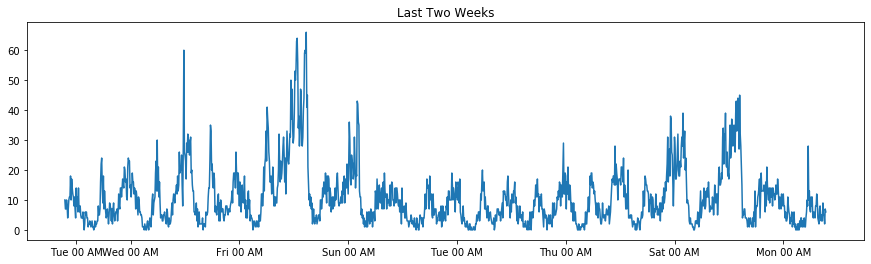

In [7]:
figsize(15,4)
fig, ax = plt.subplots()

ax.plot(agg.iloc[-1344:].hit)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %H %p'));
ax.set_title("Last Two Weeks")

Text(0.5, 1.0, 'Last Three Days')

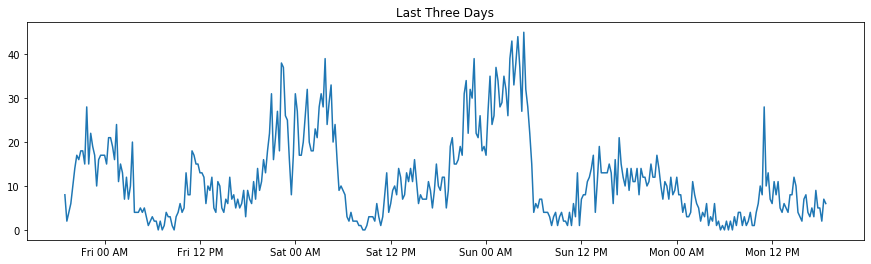

In [8]:
#patterns of the last three days of data
figsize(15,4)
fig, ax = plt.subplots()

ax.plot(agg.iloc[-384:].hit)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %H %p'));
ax.set_title("Last Three Days")

From the graphs above you can see that hits are more frequent on the weekends, spiking during the prime drinking hours of Friday night into Saturday morning and Saturday night into Sunday morning. During the week there appears to be more activity in the mornings than in the evenings.
<br>
<br>
There also appear to be patterns in the nightly fluctuations of demand. There is a spike followed by a decrease in demand right before midnight on friday night, possibly due to the closing of restaurants. The next spike is possibly due to the closing of bars.

## Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities. <br>
However, a toll bridge, with a two ­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. <br>
Please provide details on:<br>
    how you will implement the experiment<br>
    what statistical test(s) you will conduct to verify the significance of the observation?<br>
    how you would interpret the results and pro

### Experiment: Reimburse toll costs to drivers

**Key Measure of Experimental Success** <br>
The key measure of success for this experiment should be the number of rides given by Gothamite(?) drivers to Metropolis and vice versa. This metric will be a direct indicator of if drivers are crossing the bridge for rides.

**Experiment** <br>
Randomly divide the drivers for both cities into two groups and measure the number of cross-bridge trips for each. <br>
    *Group A:* recieves reimbursement for tolls <br>
    *Groub B:* control group, does not recieve reimbursement 
<br>
<br>
**Implementation** <br>
For a one week time span, measure the number of rides that originate in one city and end in the other for each group. Ideally this experiment would be repeated at least three times in weeks that are representative of "normal" activity in each city. For example, a week where a big concert festival is happening in Metropolis would not be a good time to conduct this experiment.
<br>
This type of experiment follows the typical format of A/B hypothesis testing, with the null hypothesis being: the group of drivers that recieve toll reimbursement do not take more cross-bridge trips. The shape of the final data should be analyzed for normality and possible outliers. Depending on the shape of the data different statistical tests may be used for example using a Student's T-test or a Mann-Whitney test.

### Results
This experiment would give a direct measure of if toll reimbursement is effective in convincing drivers to make the trip across the bridge more frequently. However, recommendations should be make based on how this experiment affects other metrics related to the business. Things like, wait times for rides per city, number of drivers working, and net revenue generated for Ultimate should all be assessed between the experimental and control group before making a recommendation. 

## Predictive Modeling

In [9]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
df = df.reset_index()
df = df.rename(columns={'index':'user_id'})
df.head()

,user_id,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [10]:
#missing values were found using the command below, 
#because 0 would not work for all values filling was done per column
df[df.isnull().any(axis=1)]
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(0)
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(0)
df['phone'] = df['phone'].fillna('Unknown')

In [11]:
active = df.set_index('last_trip_date').last('30D')
active['status'] = 'retained'
active = active.set_index('user_id')
active = active['status']

In [12]:
df = df.set_index('user_id')
df = df.join(active, how = 'outer')
df.fillna('not_retained', inplace=True)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,status
user_id,,,,,,,,,,,,,
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,not_retained
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,not_retained
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,not_retained
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,not_retained
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,not_retained


### Exploratory Data Analysis

In [13]:
df.groupby('status').signup_date.count()

status
not_retained    12571
retained        37429
Name: signup_date, dtype: int64

Overall Ultimate has a fairly high user retention rate around 75%. Additionally, the dataset is unbalanced in favor of retained users, this will be considered when doing model selection.

In [14]:
pd.DataFrame(df.groupby(['status','phone']).phone.count())

phone
status       phone         
not_retained Android   3780
             Unknown     87
             iPhone    8704
retained     Android  11242
             Unknown    309
             iPhone   25878

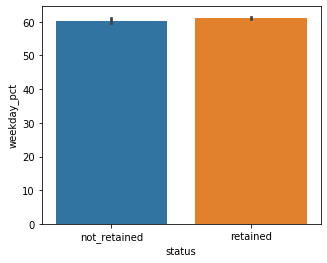

In [15]:
figsize(5,4)
sns.barplot(data = df, x = 'status', y = 'weekday_pct')

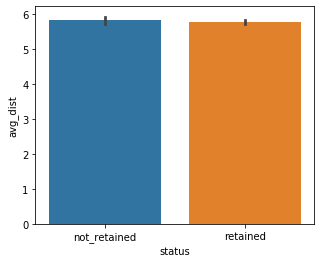

In [16]:
sns.barplot(data = df, x = 'status', y = 'avg_dist')

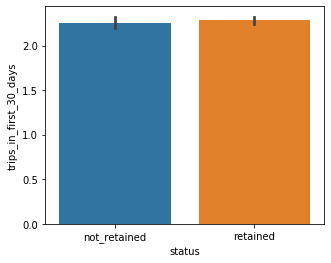

In [17]:
sns.barplot(data = df, x = 'status', y = 'trips_in_first_30_days')

Upon cursory analysis of the factors included in the data, a clear predictor of whether a user will be retained or not is not clear.

### Feature Analysis

In [18]:
#creating dummy variables for possibly predictive categorical values
df = pd.get_dummies(data=df, columns=['city','phone','ultimate_black_user'])

In [19]:
X = df[['trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'city_Astapor', 'city_King\'s Landing',
       'city_Winterfell', 'phone_Android', 'phone_Unknown', 'phone_iPhone',
       'ultimate_black_user_False', 'ultimate_black_user_True']]
y = df['status']

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#some algorithms perform better with scaled data, so StandarScaler used on features
X_scaled = scaler.fit_transform(X)

In [21]:
from sklearn.decomposition import PCA
pca = PCA()
pca_components = pca.fit(X_scaled)

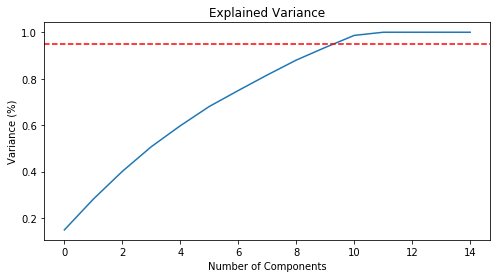

In [22]:
plt.figure(figsize=(8,4))

plt.plot(np.cumsum(pca_components.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.axhline(y=0.95, color='r',linestyle='--')
plt.title('Explained Variance')
plt.show()

Using principal component analysis, we see that we should expect around 8 components to explain the majority of the variance in these data.

To examine the importance of all features, a model will be generated for the feature sets and the coefficients will be assessed. Features that are more predictive of user retention will have stronger coefficients, which will provide insight into how user behavior affects retention.

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Feature: 0, Score: 0.00360
Feature: 1, Score: -0.00019
Feature: 2, Score: 0.01020
Feature: 3, Score: -0.00458
Feature: 4, Score: 0.01991
Feature: 5, Score: -0.01085
Feature: 6, Score: 0.00332
Feature: 7, Score: -0.00642
Feature: 8, Score: 0.01651
Feature: 9, Score: -0.00725
Feature: 10, Score: -0.00025
Feature: 11, Score: 0.01541
Feature: 12, Score: -0.00271
Feature: 13, Score: -0.00216
Feature: 14, Score: 0.00216


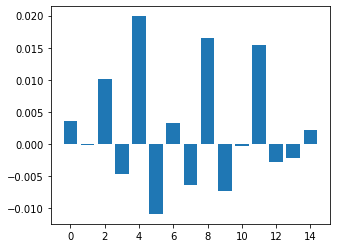

In [23]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression()
m.fit(X_scaled,y)

importance = m.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Logistic regression was the first algorithm tested because of its speed and simplicity. From this we see that the average surge a rider experiences, the percent of weekday rides taken, being a resident of the city of King's Landing, and not using a phone for the service are most strongly correlated with retaining a user. <br>
The average distance of a trip in the first 30 days of signup or being a resident of Astapor or Winterfell are the most negatively correlated with user retention.

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature: 0, Score: 0.08686
Feature: 1, Score: 0.07836
Feature: 2, Score: 0.05669
Feature: 3, Score: 0.05266
Feature: 4, Score: 0.10858
Feature: 5, Score: 0.50510
Feature: 6, Score: 0.07311
Feature: 7, Score: 0.00606
Feature: 8, Score: 0.00417
Feature: 9, Score: 0.00511
Feature: 10, Score: 0.00612
Feature: 11, Score: 0.00146
Feature: 12, Score: 0.00596
Feature: 13, Score: 0.00475
Feature: 14, Score: 0.00501


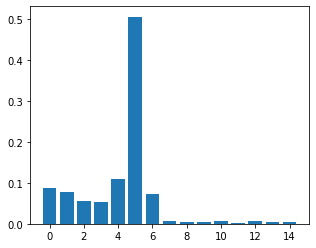

In [24]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier()
# fit the model
m.fit(X, y)

# get importance
importance = m.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Using a random forest classifier, which should handle unbalanced data better, the most significant predictor of user retention was the average distance of rides taken in the first 30 days of a user. However, trips in the first 30 days, average rating of drivers, and the percent of weekday trips taken by a user were also somewhat predictive.

### Model Creation

In [25]:
# Import the necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=21)

# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(classification_report(y_test, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

not_retained       0.00      0.00      0.00      3792
    retained       0.75      1.00      0.86     11208

    accuracy                           0.75     15000
   macro avg       0.37      0.50      0.43     15000
weighted avg       0.56      0.75      0.64     15000

Confusion Matrix: 
[[    0  3792]
 [    0 11208]]


In [27]:
from sklearn.ensemble import RandomForestClassifier

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=21)

forest = RandomForestClassifier()

forest.fit(X_train,y_train)

y_pred = forest.predict(X_test)

# Compute and print the confusion matrix and classification report
print(classification_report(y_test, y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

/Users/zosking/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

not_retained       0.25      0.17      0.21      3792
    retained       0.75      0.83      0.78     11208

    accuracy                           0.66     15000
   macro avg       0.50      0.50      0.50     15000
weighted avg       0.62      0.66      0.64     15000

Confusion Matrix: 
[[ 660 3132]
 [1947 9261]]


Logistic regression and random forest were tested to model these data. Logistic regression had better overall accuracy and f1-score, but failed to predict that a user would not be retained. The random forest model at least made some predictions of non-retention, but with low accuracy, precision, and recall.

### Conclusion

These methods have provided a useful insight into what may lead to user retention at 6 months, but overall the data are lacking. My recommendation based off of these data would be to expand on features like the average distance of travel in the first 30 days in the future to better determine retention at 6 months. 